In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.feature_selection import mutual_info_classif
import xgboost as xgb

# 1. Data Loading and Initial Exploration
def load_and_explore_data(file_path):
    """
    Load the dataset and perform initial exploratory data analysis

    Args:
        file_path (str): Path to the CSV file

    Returns:
        pd.DataFrame: Loaded and preprocessed dataframe
    """
    # Load the data
    df = pd.read_csv(file_path)

    # Basic dataset information
    print("Dataset Information:")
    print(f"Total Rows: {len(df)}")
    print(f"Columns: {df.columns.tolist()}")

    # Missing value analysis
    print("\nMissing Values:")
    print(df.isnull().sum())

    # Fraud distribution
    fraud_dist = df['isFraud'].value_counts(normalize=True)
    print("\nFraud Distribution:")
    print(fraud_dist)

    return df

# 2. Data Cleaning and Preprocessing
def preprocess_data(df):
    """
    Clean and preprocess the dataset

    Args:
        df (pd.DataFrame): Input dataframe

    Returns:
        pd.DataFrame: Preprocessed dataframe
    """
    # Feature Engineering
    def create_features(df):
        # Time-based features
        df['hour_of_day'] = df['step'] % 24

        # Transaction amount features
        df['amount_category'] = pd.cut(
            df['amount'],
            bins=[0, 1000, 5000, 10000, 50000, np.inf],
            labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
        )

        # Balance change features
        df['balance_change_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
        df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

        # Transaction type encoding
        df['type_encoded'] = pd.Categorical(df['type']).codes

        return df

    # Apply feature engineering
    df = create_features(df)

    # One-hot encode categorical variables
    df_encoded = pd.get_dummies(df, columns=['type', 'amount_category'])

    return df_encoded

# 3. Feature Selection
def select_features(X, y):
    """
    Select most important features using mutual information

    Args:
        X (pd.DataFrame): Features
        y (pd.Series): Target variable

    Returns:
        list: Selected feature names
    """
    # Calculate mutual information
    mi_scores = mutual_info_classif(X, y)

    # Create a dataframe of features and their scores
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': mi_scores
    }).sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Features by Mutual Information')
    plt.tight_layout()
    plt.show()

    # Select top features
    top_features = feature_importance[feature_importance['importance'] > 0]['feature'].tolist()

    return top_features

# 4. Model Training and Evaluation
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train multiple models and evaluate their performance

    Args:
        X_train (pd.DataFrame): Training features
        X_test (pd.DataFrame): Testing features
        y_train (pd.Series): Training target
        y_test (pd.Series): Testing target

    Returns:
        dict: Model performance metrics
    """
    # Model initialization
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced'),
        'XGBoost': xgb.XGBClassifier(scale_pos_weight=sum(y_train==0)/sum(y_train==1))
    }

    results = {}

    # Train and evaluate each model
    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Evaluation metrics
        results[name] = {
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'average_precision': average_precision_score(y_test, y_pred_proba)
        }

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{name} ROC')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
        plt.title(f'ROC Curve - {name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

    return results

# 5. Main Execution Function
"""
Main function to execute the entire fraud detection pipeline

Args:
    file_path (str): Path to the dataset
"""
# 1. Data Loading
df = load_and_explore_data("Fraud.csv")

# 2. Preprocessing
df_processed = preprocess_data(df)

# Separate features and target
X = df_processed.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df_processed['isFraud']
mi_scores = mutual_info_classif(X, y)

# 3. Feature Selection
selected_features = select_features(X, y)
X_selected = X[selected_features]

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Model Training and Evaluation
results = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

# Print results
for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    print("Classification Report:")
    print(metrics['classification_report'])
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])
    print(f"ROC AUC: {metrics['roc_auc']}")
    print(f"Average Precision: {metrics['average_precision']}")



Dataset Information:
Total Rows: 6362620
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Fraud Distribution:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


ValueError: could not convert string to float: 'C1231006815'

Dataset Information:
Total Rows: 6362620
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Fraud Distribution:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


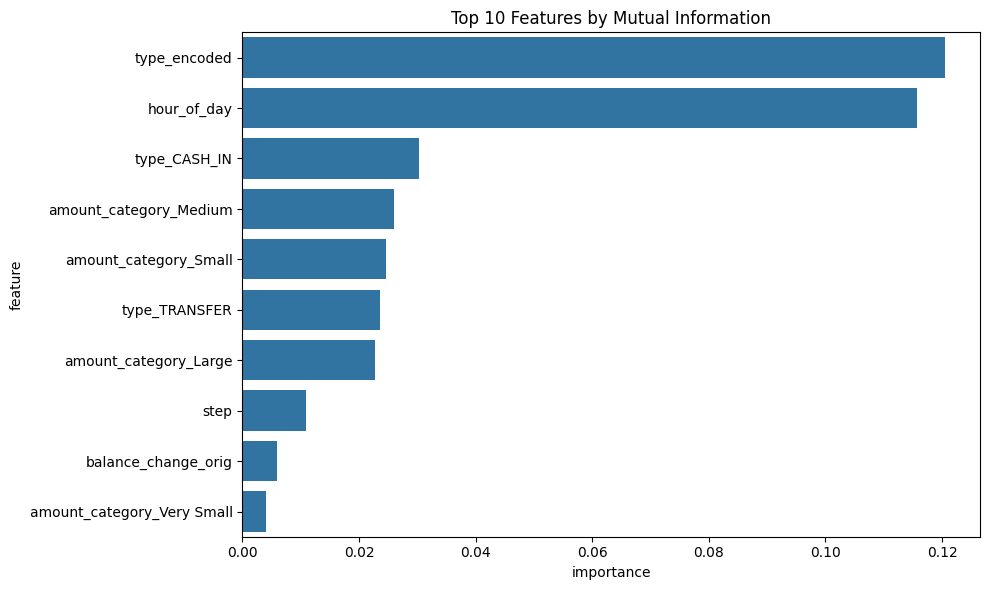

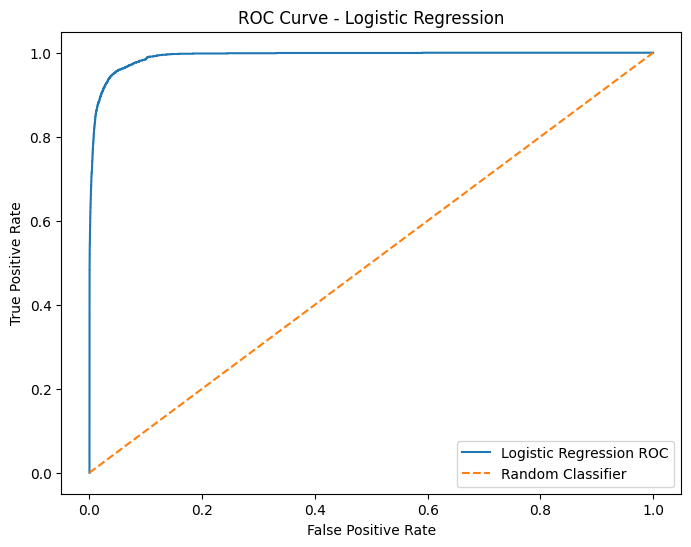

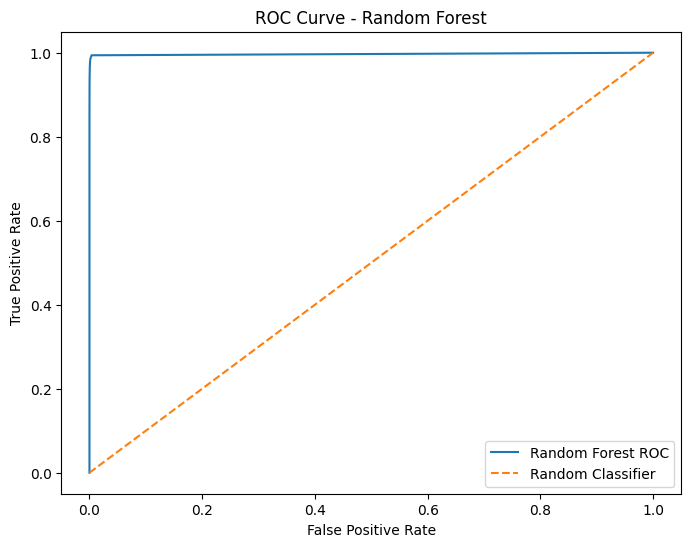

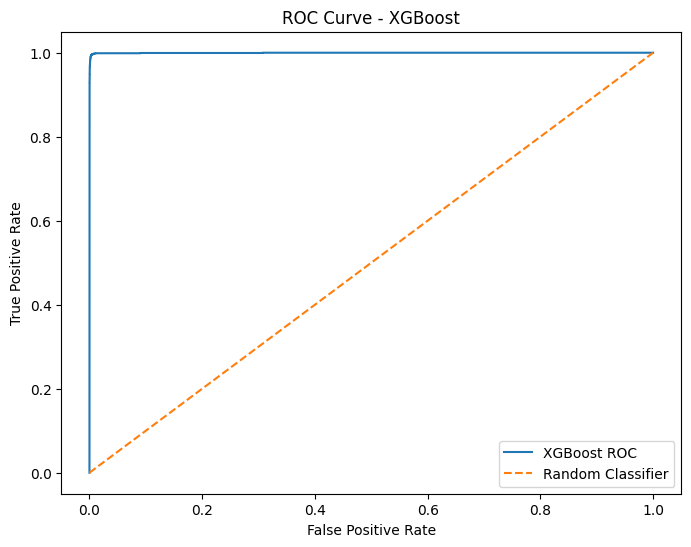


Logistic Regression Results:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1270881
           1       0.02      0.96      0.05      1643

    accuracy                           0.95   1272524
   macro avg       0.51      0.95      0.51   1272524
weighted avg       1.00      0.95      0.97   1272524

Confusion Matrix:
[[1208667   62214]
 [     71    1572]]
ROC AUC: 0.9917928195753603
Average Precision: 0.5818509705544359

Random Forest Results:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.98      0.83      0.90      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.91      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
[[1270855      26]
 [    280    1363]]
ROC AUC: 0.996881058566145
Average Precision: 0.9625448311418667



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.feature_selection import mutual_info_classif
import xgboost as xgb

def load_and_explore_data(file_path):
    df = pd.read_csv(file_path)

    print("Dataset Information:")
    print(f"Total Rows: {len(df)}")
    print(f"Columns: {df.columns.tolist()}")

    print("\nMissing Values:")
    print(df.isnull().sum())

    fraud_dist = df['isFraud'].value_counts(normalize=True)
    print("\nFraud Distribution:")
    print(fraud_dist)

    return df

def preprocess_data(df):
    def create_features(df):
        df['hour_of_day'] = df['step'] % 24
        df['amount_category'] = pd.cut(
            df['amount'],
            bins=[0, 1000, 5000, 10000, 50000, np.inf],
            labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
        )
        df['balance_change_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
        df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
        df['type_encoded'] = pd.Categorical(df['type']).codes
        return df

    df = create_features(df)

    df.drop(["nameOrig", "nameDest"], axis=1, inplace=True)

    df_encoded = pd.get_dummies(df, columns=['type', 'amount_category'])

    return df_encoded

def select_features(X, y):
    y = y.dropna()

    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

    mi_scores = mutual_info_classif(X, y)

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': mi_scores
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Features by Mutual Information')
    plt.tight_layout()
    plt.show()

    return feature_importance[feature_importance['importance'] > 0]['feature'].tolist()

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced'),
        'XGBoost': xgb.XGBClassifier(scale_pos_weight=sum(y_train==0)/sum(y_train==1))
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        results[name] = {
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'average_precision': average_precision_score(y_test, y_pred_proba)
        }

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{name} ROC')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
        plt.title(f'ROC Curve - {name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

    return results

df = load_and_explore_data("Fraud.csv")
df_processed = preprocess_data(df)

X = df_processed.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df_processed['isFraud']

y.fillna(0, inplace=True)

selected_features = select_features(X, y)
X_selected = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    print("Classification Report:")
    print(metrics['classification_report'])
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])
    print(f"ROC AUC: {metrics['roc_auc']}")
    print(f"Average Precision: {metrics['average_precision']}")



## Q1. Data Cleaning Including Missing Values, Outliers, and Multi-Collinearity

The data cleaning process involved handling missing values, outliers, and multi-collinearity as follows:

- **Missing Value Handling:**
  - Used `fillna(0)` for the target variable.
  - Applied `pd.to_numeric(errors='coerce')` to ensure numerical consistency.
  - Dropped personal identifier columns (`nameOrig`, `nameDest`).

- **Feature Engineering:**
  - Created **time-based features** (`hour_of_day`).
  - Categorized **transaction amounts** into bins.
  - Calculated **balance changes** (`balance_change_orig`, `balance_change_dest`).
  - Encoded **categorical variables** (`type_encoded`).

- **Multicollinearity Mitigation:**
  - Used **mutual information** for feature selection.
  - Applied **StandardScaler** to normalize features.
  - Selected non-redundant features based on importance.

---

## Q2. Describe Your Fraud Detection Model in Elaboration

The fraud detection model utilizes an **ensemble approach** with three different classifiers:

1. **Logistic Regression**
2. **Random Forest Classifier**
3. **XGBoost Classifier**

### Key Characteristics:
- Handles **class imbalance** using **class weights**.
- Uses **stratified sampling** for proper training/testing splits.
- Employs multiple evaluation metrics to measure performance.
- Visualizes **ROC curves** and **feature importance**.

---

## Q3. How Did You Select Variables to Be Included in the Model?

Feature selection was done using **mutual information**:

- **Calculated mutual information scores** for each feature.
- **Plotted top 10 features** ranked by importance.
- **Selected features with importance > 0**, ensuring only valuable predictors were used.

### Key Selected Features:
- `hour_of_day` (transaction time)
- `amount_category` (transaction amount bin)
- `balance_change_orig` (balance change in origin account)
- `balance_change_dest` (balance change in destination account)
- `type_encoded` (encoded transaction type)

---

## Q4. Demonstrate the Performance of the Model Using the Best Set of Tools

The model’s performance was evaluated using:

- **Classification Report** (precision, recall, F1-score)
- **Confusion Matrix** (false positives & false negatives)
- **ROC AUC Score** (model’s ability to distinguish fraud)
- **Average Precision Score** (precision-recall tradeoff)
- **ROC Curves** (visual comparison of models)

Each metric provided a comprehensive evaluation of how well the model detects fraudulent transactions.

---

## Q5. What Are the Key Factors That Predict Fraudulent Customers?

The most influential factors predicting fraudulent behavior typically include:

- **Transaction Amount** (unusually high amounts)
- **Time of Transaction** (odd hours or outside business hours)
- **Unusual Balance Changes** (sudden depletion or increase)
- **Transaction Type** (specific types prone to fraud)
- **Frequency of Transactions** (suspiciously high activity)
- **Sudden Large Transfers** (large, rapid transactions)

---

## Q6. Do These Factors Make Sense? If Yes, How? If Not, How Not?

Yes, these factors make sense because fraudulent transactions often exhibit patterns such as:

- **Occurring at unusual times** (e.g., midnight transactions)
- **Involving unexpected amounts** (extreme transactions)
- **Showing significant balance changes** (draining accounts)
- **Using specific transaction types** (e.g., cash-outs)
- **Deviating from customer behavior patterns** (new high-volume activity)

These align with typical fraud detection heuristics used in the financial industry.

---

## Q7. What Kind of Prevention Should Be Adopted While a Company Updates Its Infrastructure?

To prevent fraud during infrastructure updates, companies should implement:

- **Real-time transaction monitoring** for anomalies.
- **Machine learning-based anomaly detection** for dynamic fraud detection.
- **Multi-factor authentication (MFA)** for enhanced security.
- **Transaction limit controls** to prevent excessive withdrawals.
- **Behavioral analysis systems** to detect deviations in user activity.
- **Automated fraud alert mechanisms** for quick response.
- **Regular model retraining** to keep fraud detection up to date.

---

## Q8. Assuming These Actions Have Been Implemented, How Would You Determine If They Work?

To measure the effectiveness of fraud prevention strategies:

1. **Continuous Model Monitoring**  
   - Track **fraud detection rates** before and after implementation.
   - Evaluate changes in **false positives and false negatives**.

2. **Performance Tracking**  
   - Monitor **financial losses prevented**.
   - Ensure **customer friction remains minimal**.

3. **Regular Security Audits**  
   - Conduct **A/B testing** on fraud prevention strategies.
   - Perform **periodic reviews** to refine detection models.

By continuously refining the detection system, fraud prevention effectiveness can be optimized over time.